In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import sys,os,csv,time,glob
import torchvision.transforms as transforms
import random
import torch
import numpy as np
import torch
from torch import optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import argparse
from torchvision.utils import save_image
import torch.nn.functional as F
from random import randint
from IPython.display import Image
from IPython.core.display import Image, display

In [2]:
n_epoch = 100
batch_size = 128
learning_rate = 1e-3

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def get_dataset(root):
    #fnames = glob.glob(os.path.join(root, '*.'))
    fnames = glob.glob('%s/*/*.jpg'%root)
    # resize the image to (64, 64)
    # linearly map [0, 1] to [-1, 1]
    transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((64, 64)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3) ] )
    dataset = FaceDataset(fnames, transform)
    return dataset

class FaceDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(fname)
        img = self.BGR2RGB(img) #because "torchvision.utils.save_image" use RGB
        img = self.transform(img)
        return img,fname

    def __len__(self):
        return self.num_samples

    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
dir_na = './cats_bigger_than_64x64'

dataset = get_dataset(dir_na)

In [6]:
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [8]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
model = VAE(image_channels=3).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x,reduction='mean')
    #BCE = F.mse_loss(recon_x, x, reduction='mean')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [10]:
t_batch = dataloader.__len__()
n_sample = dataset.__len__()
outputs = []
best_loss =  float("inf")
LOSS= []
for epoch in range(n_epoch):
    train_loss = 0.0
    epoch_start_time = time.time()
    for i, (imgs,_) in enumerate(dataloader):

        imgs = imgs.cuda()
        # ===================forward====================
        recon_imgs, mu, logvar = model(imgs)
        loss, bce, kld = loss_fn(recon_imgs, imgs, mu, logvar)
        #_, loss, _ = loss_fn(recon_imgs, imgs, mu, logvar)
        train_loss += bce.item()
        # ===================backward===================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        progress = ('#' * int(float(i)/t_batch*15)).ljust(15)
        print ('[%03d/%03d] %2.2f sec(s) | %s |' % (epoch+1, n_epoch, \
                    (time.time() - epoch_start_time), progress), end='\r', flush=True)
    
    train_loss /= t_batch
    LOSS.append(train_loss)
    print('[%03d/%03d] %2.2f sec(s) Train Loss: %3.6f' % \
            (epoch + 1, n_epoch, time.time()-epoch_start_time,train_loss))
    
    if train_loss < best_loss:
        model_dir = './autoencoder'
        best_loss = train_loss
        os.makedirs(model_dir, exist_ok=True)
        path = os.path.join(model_dir,'model_best')
        torch.save(model.state_dict(),path)
        print('saving model with loss %3.6f'%best_loss)
        with open(os.path.join(model_dir,'loss.txt'),'w',newline='')as csvfile:
                csvfile.write(str(epoch)+'\t'+str(best_loss)+'\n')
    

[001/100] 9.48 sec(s) Train Loss: -3.329657
saving model with loss -3.329657
[002/100] 9.61 sec(s) Train Loss: -3.709981
saving model with loss -3.709981
[003/100] 9.51 sec(s) Train Loss: -3.981585
saving model with loss -3.981585
[004/100] 9.54 sec(s) Train Loss: -4.107803
saving model with loss -4.107803
[005/100] 9.56 sec(s) Train Loss: -4.082665
[006/100] 9.53 sec(s) Train Loss: -3.926039
[007/100] 9.48 sec(s) Train Loss: -3.958073
[008/100] 9.49 sec(s) Train Loss: -4.110195
saving model with loss -4.110195
[009/100] 9.52 sec(s) Train Loss: -4.078565
[010/100] 9.54 sec(s) Train Loss: -4.117837
saving model with loss -4.117837
[011/100] 9.53 sec(s) Train Loss: -4.028810
[012/100] 9.48 sec(s) Train Loss: -3.930561
[013/100] 9.47 sec(s) Train Loss: -3.820926
[014/100] 9.51 sec(s) Train Loss: -3.938806
[015/100] 9.57 sec(s) Train Loss: -4.102235
[016/100] 9.50 sec(s) Train Loss: -4.075785
[017/100] 9.51 sec(s) Train Loss: -3.950025
[018/100] 9.48 sec(s) Train Loss: -3.984978
[019/100] 

KeyboardInterrupt: 

In [11]:
model_dir = './autoencoder'
path = os.path.join(model_dir,'model_best')
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [12]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])

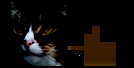

In [20]:
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x.to(device))

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))